In [1]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['c:\\Users\\anaxa\\Documents\\Projects\\BAMT', 'c:\\Users\\anaxa\\Documents\\Projects', 'c:\\Users\\anaxa\\Documents\\Projects\\BAMT\\experiments']


In [2]:
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from bamt.Preprocessors import Preprocessor
from bamt.ScoringFunctions import BICGMM, BICGauss, BIC_local, BIC_local_gauss
from bamt.mi_entropy_gauss import mi_gauss
import bamt.Networks as Nets
from pgmpy.estimators import K2Score, BicScore
from pgmpy.estimators import HillClimbSearch
import networkx as nx
from bamt.utils.MathUtils import *
from gmr import GMM
from sklearn.metrics import mean_squared_error

In [73]:
data = pd.read_csv('../Data/daks_processed_with_rf_ntg.csv')
data


,Field name,Reservoir unit,Country,Region,Tectonic regime,Onshore/offshore,Hydrocarbon type,Productive area,Period,Depositional system,...,Permeability,Structural setting,Trapping mechanism,Depth,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor,NTG,NTG_calc
0,A.J.BERMUDEZ,UNNAMED (CUNDUACAN FIELD),MEXICO,LATIN AMERICA,COMPRESSION,ONSHORE,OIL,NaN,CRETACEOUS,FORESLOPE,...,NaN,WRENCH,FOLD,3819.8,876.160991,0.33,NaN,NaN,NaN,NaN
1,A.J.BERMUDEZ,UNNAMED (SAMARIA FIELD),MEXICO,LATIN AMERICA,COMPRESSION,ONSHORE,OIL,24700.0,CRETACEOUS,FORESLOPE,...,NaN,WRENCH,FOLD,4120.1,876.160991,0.25,NaN,NaN,NaN,NaN
2,AB TEYMUR,ILAM,IRAN,MIDDLE EAST,COMPRESSION,ONSHORE,OIL,130910.0,CRETACEOUS,LOW-ENERGY CARBONATE MUD,...,NaN,FORELAND,FOLD,3063.1,904.153355,0.13,NaN,NaN,0.650,0.668255
3,AB TEYMUR,SARVAK-1,IRAN,MIDDLE EAST,COMPRESSION,ONSHORE,OIL,133380.0,CRETACEOUS,LOW-ENERGY CARBONATE MUD,...,NaN,FORELAND,FOLD,3263.1,909.967846,0.13,NaN,NaN,0.750,0.730104
4,ABKATUN,TAMABRA,MEXICO,LATIN AMERICA,COMPRESSION,OFFSHORE,OIL,58045.0,CRETACEOUS-PALEOGENE,FORESLOPE,...,3.1,SALT,FOLD,2920.7,887.147335,0.40,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,ПРИОБСКОЕ,Пласт: АС 10.0-1,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,23.6,NaN,NaN,2487.0,880.800000,NaN,NaN,NaN,0.765,0.159504
1108,ПРИОБСКОЕ,Пласт: АС 10.1-3,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,32.7,NaN,NaN,2624.0,NaN,NaN,NaN,NaN,0.700,0.399123
1109,ПРИОБСКОЕ,Пласт: АС 10.4,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,33.4,NaN,NaN,2604.0,NaN,NaN,NaN,NaN,0.685,0.209756
1110,ПРИОБСКОЕ,Пласт: АС 12.1,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,28.7,NaN,NaN,2628.0,875.450000,NaN,NaN,NaN,0.755,0.958904


In [74]:
true_net = pd.read_csv('geology_expert.csv', sep=';')
true_net

,V1,V2
0,Region,Tectonic regime
1,Region,Hydrocarbon type
2,Region,Depositional system
3,Region,Depositional environment
4,Tectonic regime,Region
...,...,...
162,Condensate recovery factor,NTG_calc
163,Gas recovery factor,Gross
164,Gas recovery factor,Netpay
165,Gas recovery factor,NTG


In [75]:
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'NTG']
data = data[cols]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth,NTG
0,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,227.1,43.9,10.0,8.0,3134.8,0.23
1,STRIKE-SLIP,NEOGENE,THINLY-BEDDED SANDSTONE,WRENCH,35.1,20.1,22.0,200.0,3000.9,0.60
2,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,155.2,125.0,20.0,300.0,3200.9,0.80
3,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,76.2,30.5,21.0,60.0,1510.7,0.40
4,GRAVITY,CRETACEOUS,LIMESTONE,PASSIVE MARGIN,29.0,4.6,12.0,20.0,2652.4,0.16
...,...,...,...,...,...,...,...,...,...,...
378,GRAVITY,CRETACEOUS,LIMESTONE,SALT,44.8,27.4,25.0,60.0,2393.3,0.61
379,EXTENSION,PALEOGENE,SANDSTONE,RIFT,210.1,58.5,22.4,126.0,1690.5,0.20
380,EXTENSION,PALEOGENE,SANDSTONE,RIFT,89.9,24.1,21.0,60.0,2310.7,0.20
381,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,79.9,10.1,24.0,30.0,570.1,0.10


In [76]:
expert_net = []
for i in range(true_net.shape[0]):
    if (true_net.loc[i,'V1'] in cols) & (true_net.loc[i,'V2'] in cols):
        expert_net.append((true_net.loc[i,'V1'], true_net.loc[i,'V2']))

In [90]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

p = Preprocessor([('encoder', encoder), ('discretizer', discretizer)])

discretized_data, est = p.apply(data)

bn = Nets.HybridBN(use_mixture=True, has_logit=False)
info = p.info

bn.add_nodes(info)

In [91]:
#params = {'init_edges': expert_net, 'remove_init_edges': True}
params = {'white_list': expert_net}
bn.add_edges(discretized_data, scoring_function=('K2',K2Score), params=params)

  0%|          | 7/1000000 [00:00<8:53:26, 31.24it/s] 


In [92]:
bn.fit_parameters(data)

In [93]:
pred = dict()
for c in data.columns:
    test = data.drop(columns=[c])
    pred[c] = bn.predict(test, 11)

100%|██████████| 383/383 [00:00<00:00, 683.93it/s]


In [94]:
cols = ['Gross','Netpay','Porosity','Permeability', 'Depth', 'NTG']
for c in cols:
    pred_val = pred[c][c]
    print(c)
    print(mean_squared_error(data[c].values, pred_val, squared=False))

Gross
369.0116209234497
Netpay
85.57819379871242
Porosity
5.726384726139752
Permeability
991.6696237345508
Depth
1082.9181737329006
NTG
0.15310763209918832


In [95]:
data = pd.read_csv('asia.csv')
encoder = preprocessing.LabelEncoder()
p = Preprocessor([('encoder', encoder)])

discretized_data, est = p.apply(data)

bn = Nets.DiscreteBN()
bn.add_nodes(p.info)
structure = [('asia', 'tub'), ('smoke', 'lung')]
bn.set_structure(structure)


2022-04-06 17:13:50,265 | INFO     | Preprocessors.py-scan-0087 | No one column is continuous


In [84]:
learn_edges = []
for e in bn.edges:
    learn_edges.append((e[0], e[1]))

In [85]:
all_edges = learn_edges
for e in expert_net:
    G = nx.DiGraph()
    edge = learn_edges + [e]
    G.add_edges_from(edge)
    if len(list(nx.simple_cycles(G))) == 0:
        all_edges.append((e))

In [86]:
bn = Nets.HybridBN(use_mixture=True, has_logit=False)
info = p.info

bn.add_nodes(info)

bn.set_edges(all_edges)

In [87]:
bn.fit_parameters(data)

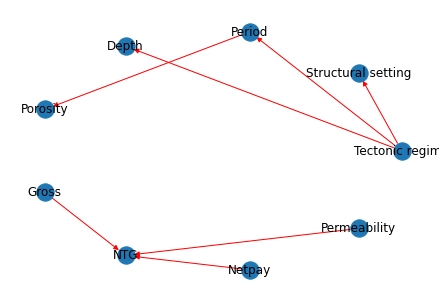

In [39]:
G = nx.DiGraph()
G.add_edges_from(bn.edges)
colors = []
for e in G.edges:
    if e in expert_net:
        colors.append('red')
    else:
        colors.append('black')

nx.draw_circular(G, edge_color=colors, with_labels=True)

In [29]:
for c in nx.simple_cycles(G):
    print(c)

['Lithology', 'Structural setting', 'Period']
['Period', 'Structural setting']
['Depth', 'Permeability', 'Porosity']
['Porosity', 'Permeability']
